# Test model output

The following notebook contains tests of the output generated by model.
The tests check the legality of predicted moves and the correctness of predicted game result.

The tests are performed for model trained on simple tokenization (11 tokens)

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-simple'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(11, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=11, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos, stom, separator = meta['stoi'], meta['itos'], meta['stom'], meta['separator']
split = lambda s: list(s) if separator == '' else s.split(separator)
encode = lambda s: [stoi[c] for c in split(s)]
decode = lambda l: separator.join(itos[i] for i in l)
str_to_moves = lambda s: ''.join(stom[c] for c in split(s))
ids_to_moves = lambda l: ''.join(stom[itos[i]] for i in l)

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Legal move and game result prediction

In [6]:
def test_legal_move_and_game_result_prediction(data):
    move_seqs = set()
    correct_legal, total_legal = 0, 0
    correct_result, total_result = 0, 0

    for seq in data:
        engine = C4Engine()
        seq_moves = ids_to_moves(seq)
        for i in range(len(seq)):
            engine.make_move(seq_moves[i])

            if seq_moves[:i+1] in move_seqs:
                continue
            move_seqs.add(seq_moves[:i+1])

            # predict next token (move or game result)
            x = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
            y = model.generate(idx=x, max_new_tokens=1, top_k=1)
            predicted = ids_to_moves(y[0].tolist())[-1]

            # if game finished check predicted result
            if engine.result() is not None:
                if predicted == engine.result():
                    correct_result += 1
                total_result += 1
                break

            # check if predicted move is legal
            if engine.is_legal_move(predicted):
                correct_legal += 1
            total_legal += 1

    return correct_legal, total_legal, correct_result, total_result

In [7]:
correct_legal_val, total_legal_val, correct_result_val, total_result_val = test_legal_move_and_game_result_prediction(val_data)

In [8]:
print(f"Legal moves predicted (validation data): {correct_legal_val}/{total_legal_val} ({100.0*correct_legal_val/total_legal_val:.2f}%)")
print(f"Game result predicted (validation data): {correct_result_val}/{total_result_val} ({100.0*correct_result_val/total_result_val:.2f}%)")

Legal moves predicted (validation data): 59234/59665 (99.28%)
Game result predicted (validation data): 1691/2000 (84.55%)


In [9]:
correct_legal_train, total_legal_train, correct_result_train, total_result_train = test_legal_move_and_game_result_prediction(train_data)

In [10]:
print(f"Legal moves predicted (training data): {correct_legal_train}/{total_legal_train} ({100.0*correct_legal_train/total_legal_train:.2f}%)")
print(f"Game result predicted (training data): {correct_result_train}/{total_result_train} ({100.0*correct_result_train/total_result_train:.2f}%)")

Legal moves predicted (training data): 495689/498639 (99.41%)
Game result predicted (training data): 16097/18000 (89.43%)


## Probing

### Get output from hidden layers of the model

In [11]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [12]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}
rng = np.random.default_rng(seed=9128)

def get_probe_dataset(data):
    move_seqs = set()
    X = []
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = rng.integers(1, len(seq))
        seq_moves = ids_to_moves(seq[:i])
        # seq_moves = ids_to_moves(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_moves[i])
        engine = C4Engine(seq_moves)

        # if seq_moves[:i+1] in move_seqs:
        #     continue
        # move_seqs.add(seq_moves[:i+1])
        if seq_moves in move_seqs:
            continue
        move_seqs.add(seq_moves)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        X.append(activations['block_5'][:, -1, :].reshape(-1).cpu())
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    X = torch.stack(X)
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, Y_cell, Y_col, Y_row

In [13]:
train_X, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [14]:
train_X.shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16304, 384]),
 torch.Size([16304, 42]),
 torch.Size([16304, 7]),
 torch.Size([16304, 6]))

In [15]:
val_X, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [16]:
val_X.shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1892, 384]),
 torch.Size([1892, 42]),
 torch.Size([1892, 7]),
 torch.Size([1892, 6]))

### Train linear probes

In [17]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [18]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [19]:
def train_probe(X, Y, num_cls):
    probe = LinearBoardProbe(dim_x=X.shape[-1], dim_y=Y.shape[-1], num_cls=num_cls).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        probe.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    epochs = 1024
    batch_size = 1024

    train_loader = get_data_loader(X, Y, batch_size)

    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)

            loss = criterion(
                preds.view(-1, probe._num_cls),
                y.view(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

    return probe, train_loader

Predict value of each cell

In [20]:
cell_probe, cell_train_loader = train_probe(train_X, train_Y_cell, num_cls=3)

Epoch   0: 1.4372
Epoch   1: 0.9264
Epoch   2: 0.7874
Epoch   3: 0.7122
Epoch   4: 0.6620
Epoch   5: 0.6260
Epoch   6: 0.5991
Epoch   7: 0.5783
Epoch   8: 0.5616
Epoch   9: 0.5480
Epoch  10: 0.5366
Epoch  11: 0.5269
Epoch  12: 0.5188
Epoch  13: 0.5113
Epoch  14: 0.5050
Epoch  15: 0.4995
Epoch  16: 0.4942
Epoch  17: 0.4897
Epoch  18: 0.4854
Epoch  19: 0.4815
Epoch  20: 0.4780
Epoch  21: 0.4747
Epoch  22: 0.4717
Epoch  23: 0.4691
Epoch  24: 0.4662
Epoch  25: 0.4637
Epoch  26: 0.4615
Epoch  27: 0.4593
Epoch  28: 0.4572
Epoch  29: 0.4550
Epoch  30: 0.4533
Epoch  31: 0.4517
Epoch  32: 0.4498
Epoch  33: 0.4482
Epoch  34: 0.4469
Epoch  35: 0.4452
Epoch  36: 0.4439
Epoch  37: 0.4425
Epoch  38: 0.4412
Epoch  39: 0.4399
Epoch  40: 0.4387
Epoch  41: 0.4376
Epoch  42: 0.4364
Epoch  43: 0.4354
Epoch  44: 0.4345
Epoch  45: 0.4335
Epoch  46: 0.4325
Epoch  47: 0.4319
Epoch  48: 0.4307
Epoch  49: 0.4297
Epoch  50: 0.4289
Epoch  51: 0.4280
Epoch  52: 0.4272
Epoch  53: 0.4264
Epoch  54: 0.4255
Epoch  55:

Predict number of pieces in each column

In [21]:
col_probe, col_train_loader = train_probe(train_X, train_Y_col, num_cls=7)

Epoch   0: 2.5230
Epoch   1: 1.7362
Epoch   2: 1.4534
Epoch   3: 1.2917
Epoch   4: 1.1840
Epoch   5: 1.1040
Epoch   6: 1.0410
Epoch   7: 0.9898
Epoch   8: 0.9472
Epoch   9: 0.9110
Epoch  10: 0.8799
Epoch  11: 0.8527
Epoch  12: 0.8290
Epoch  13: 0.8074
Epoch  14: 0.7878
Epoch  15: 0.7701
Epoch  16: 0.7541
Epoch  17: 0.7392
Epoch  18: 0.7252
Epoch  19: 0.7125
Epoch  20: 0.7004
Epoch  21: 0.6895
Epoch  22: 0.6793
Epoch  23: 0.6697
Epoch  24: 0.6602
Epoch  25: 0.6516
Epoch  26: 0.6430
Epoch  27: 0.6352
Epoch  28: 0.6279
Epoch  29: 0.6204
Epoch  30: 0.6139
Epoch  31: 0.6074
Epoch  32: 0.6015
Epoch  33: 0.5947
Epoch  34: 0.5889
Epoch  35: 0.5839
Epoch  36: 0.5783
Epoch  37: 0.5731
Epoch  38: 0.5680
Epoch  39: 0.5633
Epoch  40: 0.5585
Epoch  41: 0.5538
Epoch  42: 0.5493
Epoch  43: 0.5455
Epoch  44: 0.5412
Epoch  45: 0.5371
Epoch  46: 0.5335
Epoch  47: 0.5298
Epoch  48: 0.5261
Epoch  49: 0.5224
Epoch  50: 0.5188
Epoch  51: 0.5154
Epoch  52: 0.5119
Epoch  53: 0.5088
Epoch  54: 0.5055
Epoch  55:

Predict number of pieces in each row

In [22]:
row_probe, row_train_loader = train_probe(train_X, train_Y_row, num_cls=8)

Epoch   0: 2.6524
Epoch   1: 1.7979
Epoch   2: 1.5189
Epoch   3: 1.3695
Epoch   4: 1.2708
Epoch   5: 1.1984
Epoch   6: 1.1434
Epoch   7: 1.0989
Epoch   8: 1.0624
Epoch   9: 1.0317
Epoch  10: 1.0056
Epoch  11: 0.9828
Epoch  12: 0.9637
Epoch  13: 0.9456
Epoch  14: 0.9293
Epoch  15: 0.9154
Epoch  16: 0.9029
Epoch  17: 0.8906
Epoch  18: 0.8793
Epoch  19: 0.8693
Epoch  20: 0.8603
Epoch  21: 0.8513
Epoch  22: 0.8428
Epoch  23: 0.8356
Epoch  24: 0.8279
Epoch  25: 0.8211
Epoch  26: 0.8142
Epoch  27: 0.8083
Epoch  28: 0.8026
Epoch  29: 0.7975
Epoch  30: 0.7922
Epoch  31: 0.7865
Epoch  32: 0.7818
Epoch  33: 0.7768
Epoch  34: 0.7724
Epoch  35: 0.7687
Epoch  36: 0.7641
Epoch  37: 0.7603
Epoch  38: 0.7566
Epoch  39: 0.7533
Epoch  40: 0.7488
Epoch  41: 0.7453
Epoch  42: 0.7424
Epoch  43: 0.7392
Epoch  44: 0.7359
Epoch  45: 0.7327
Epoch  46: 0.7300
Epoch  47: 0.7270
Epoch  48: 0.7242
Epoch  49: 0.7209
Epoch  50: 0.7183
Epoch  51: 0.7157
Epoch  52: 0.7134
Epoch  53: 0.7112
Epoch  54: 0.7089
Epoch  55:

### Test linear probes

In [23]:
def eval_probe(probe, loader, dim):
    correct = torch.zeros(dim, device=DEVICE)
    total = torch.zeros(dim, device=DEVICE)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)
            pred_cls = preds.argmax(dim=-1)
            matches = (pred_cls == y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

    return correct / total

In [24]:
def plot_heatmap(acc, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False):
    board = acc.view(h, w).cpu()

    plt.figure()
    plt.imshow(board)
    plt.colorbar(label='Accuracy')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if disable_yticks:
        plt.yticks([])
    if disable_xticks:
        plt.xticks([])

    for i in range(h):
        for j in range(w):
            val = board[i, j].item()
            plt.text(
                j, i,
                f'{val:.2f}',
                ha='center',
                va='center'
            )

    plt.show()

Per cell

In [25]:
train_acc_cell = eval_probe(cell_probe, cell_train_loader, dim=train_Y_cell.shape[-1])
train_acc_cell

tensor([0.8986, 0.8940, 0.9009, 0.8820, 0.9235, 0.9536, 0.9733, 0.8461, 0.8354,
        0.8310, 0.8170, 0.8703, 0.9151, 0.9523, 0.7859, 0.7764, 0.7688, 0.7585,
        0.8091, 0.8611, 0.9132, 0.7644, 0.7547, 0.7475, 0.7445, 0.7827, 0.8243,
        0.8847, 0.7383, 0.7111, 0.7050, 0.6836, 0.7444, 0.7815, 0.8387, 0.6971,
        0.6893, 0.6886, 0.7279, 0.7022, 0.7328, 0.7747], device='cuda:0')

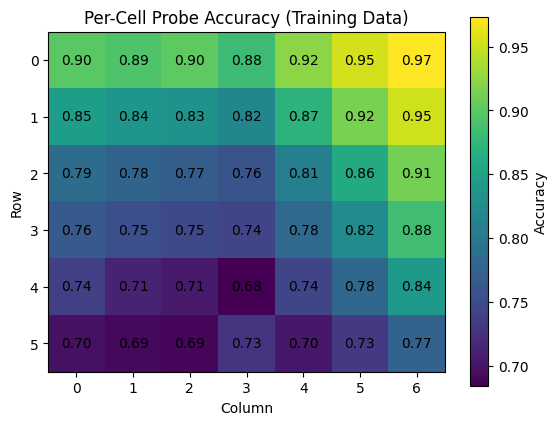

In [26]:
plot_heatmap(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [27]:
cell_val_loader = get_data_loader(val_X, val_Y_cell)
val_acc_cell = eval_probe(cell_probe, cell_val_loader, val_Y_cell.shape[-1])
val_acc_cell

tensor([0.8790, 0.8758, 0.8726, 0.8837, 0.8948, 0.9371, 0.9693, 0.8266, 0.8103,
        0.7992, 0.7875, 0.8430, 0.8916, 0.9424, 0.7706, 0.7648, 0.7431, 0.7289,
        0.7970, 0.8383, 0.9054, 0.7426, 0.7336, 0.7151, 0.7347, 0.7415, 0.7970,
        0.8668, 0.7347, 0.6802, 0.6649, 0.6644, 0.7188, 0.7574, 0.8198, 0.6728,
        0.6786, 0.6749, 0.7061, 0.6977, 0.6982, 0.7400], device='cuda:0')

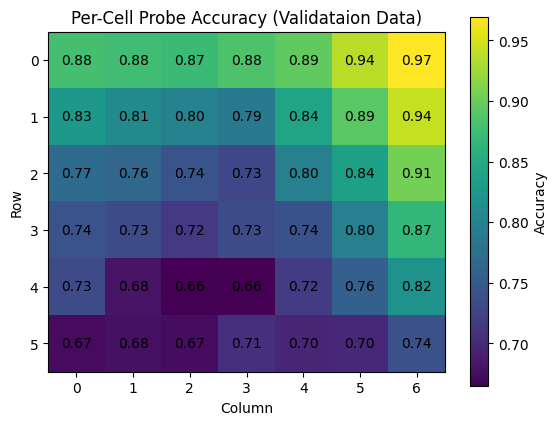

In [28]:
plot_heatmap(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [29]:
train_acc_col = eval_probe(col_probe, col_train_loader, dim=train_Y_col.shape[-1])
train_acc_col

tensor([0.9427, 0.9350, 0.9439, 0.9593, 0.9342, 0.9226, 0.9243],
       device='cuda:0')

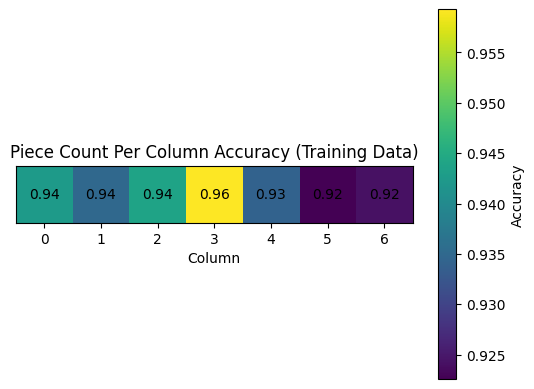

In [30]:
plot_heatmap(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [31]:
col_val_loader = get_data_loader(val_X, val_Y_col)
val_acc_col = eval_probe(col_probe, col_val_loader, val_Y_col.shape[-1])
val_acc_col

tensor([0.9260, 0.9096, 0.9197, 0.9408, 0.9091, 0.8927, 0.8964],
       device='cuda:0')

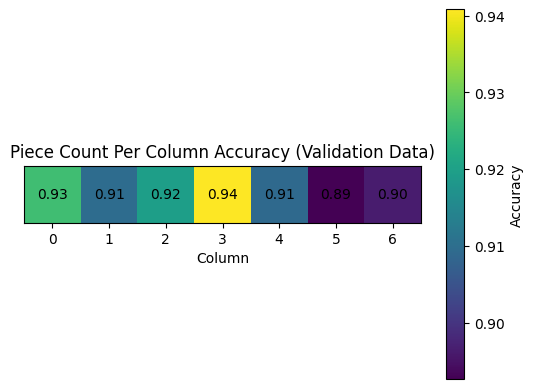

In [32]:
plot_heatmap(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [33]:
train_acc_row = eval_probe(row_probe, row_train_loader, dim=train_Y_row.shape[-1])
train_acc_row

tensor([0.9053, 0.7834, 0.7811, 0.7902, 0.7834, 0.8248], device='cuda:0')

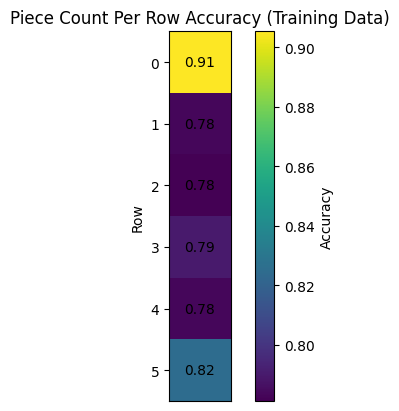

In [34]:
plot_heatmap(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [35]:
row_val_loader = get_data_loader(val_X, val_Y_row)
val_acc_row = eval_probe(row_probe, row_val_loader, val_Y_row.shape[-1])
val_acc_row

tensor([0.8774, 0.7590, 0.7347, 0.7447, 0.7452, 0.8039], device='cuda:0')

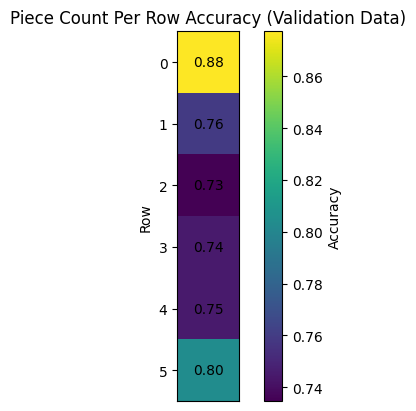

In [36]:
plot_heatmap(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)